# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться **прогнозировать отток клиентов.** Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Оператор предоставляет два основных типа услуг:** 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*)

**Также доступны такие услуги:**

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.



# Проект: отток клиентов

# Задача

Необходимо построить модель машинного обучения, которая бы прогнозировала отток клиентов. Необходимо получить метрику ROC-AUC > 0.85.

In [1]:
!pip install -U -q shap

In [2]:
!pip install -U -q phik

In [3]:
!pip install -U -q seaborn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV,  StratifiedKFold
from sklearn import set_config

from catboost import CatBoostClassifier, cv, Pool

import shap
shap.initjs()
RANDOM_STATE = 220523
TEST_SIZE = 0.25
plt.style.use('fivethirtyeight')

Загрузим данные и посмотрим на их содержание:

In [5]:
phone = pd.read_csv('phone_new.csv')
internet = pd.read_csv('internet_new.csv')
personal = pd.read_csv('personal_new.csv')
contract = pd.read_csv('contract_new.csv')

In [6]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [7]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [8]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [9]:
contract.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

Заметим, что в каждой таблице **есть ключ customerID, по которому мы можем объединить эти таблицы!**

Проверим, дублируется ли ключ в таблице contract

In [10]:
contract.customerID.shape, contract.customerID.nunique()

((7043,), 7043)

Проверим, дублируется ли ключ в таблице personal

In [11]:
personal.customerID.shape, personal.customerID.nunique()

((7043,), 7043)

Проверим, дублируется ли ключ в таблице internet

In [12]:
internet.customerID.shape, internet.customerID.nunique()

((5517,), 5517)

Проверим, дублируется ли ключ в таблице phone

In [13]:
phone.customerID.shape, phone.customerID.nunique()

((6361,), 6361)

**Объединим таблицы с помощью метода merge**

In [14]:
df_1 = pd.merge(personal, contract, how='left', on='customerID')
df_2 = pd.merge(df_1, phone, how='left', on='customerID')
data = pd.merge(df_2, internet, how='left', on='customerID')


# EDA + Отбор признаков

Теперь, после объединения переименуем столбцы в snake_case

In [15]:
data.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies']

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   begin_date         7043 non-null   object 
 6   end_date           7043 non-null   object 
 7   type               7043 non-null   object 
 8   paperless_billing  7043 non-null   object 
 9   payment_method     7043 non-null   object 
 10  monthly_charges    7043 non-null   float64
 11  total_charges      7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

**Сразу обратим внимание, что столбец total_charges определился как object. Сделаем приведение типов к типу float, заранее проверив его на ошибки**

In [17]:
data[data['total_charges'] == ' ']

customer_id  gender  senior_citizen partner dependents  begin_date  \
488   4472-LVYGI  Female               0     Yes        Yes  2020-02-01   
753   3115-CZMZD    Male               0      No        Yes  2020-02-01   
936   5709-LVOEQ  Female               0     Yes        Yes  2020-02-01   
1082  4367-NUYAO    Male               0     Yes        Yes  2020-02-01   
1340  1371-DWPAZ  Female               0     Yes        Yes  2020-02-01   
3331  7644-OMVMY    Male               0     Yes        Yes  2020-02-01   
3826  3213-VVOLG    Male               0     Yes        Yes  2020-02-01   
4380  2520-SGTTA  Female               0     Yes        Yes  2020-02-01   
5218  2923-ARZLG    Male               0     Yes        Yes  2020-02-01   
6670  4075-WKNIU  Female               0     Yes        Yes  2020-02-01   
6754  2775-SEFEE    Male               0      No        Yes  2020-02-01   

     end_date      type paperless_billing             payment_method  \
488        No  Two year               Yes  Bank transfer (automatic)   
753        No  Two year                No               Mailed check   
936        No  Two year                No               Mailed check   
1082       No  Two year                No               Mailed check   
1340       No  Two year                No    Credit card (automatic)   
3331       No  Two year                No               Mailed check   
3826       No  Two year                No               Mailed check   
4380       No  Two year                No               Mailed check   
5218       No  One year               Yes               Mailed check   
6670       No  Two year                No               Mailed check   
6754       No  Two year               Yes  Bank transfer (automatic)   

      monthly_charges total_charges multiple_lines internet_service  \
488             52.55                          NaN              DSL   
753             20.25                           No              NaN   
936             80.85                           No              DSL   
1082            25.75                          Yes              NaN   
1340            56.05                          NaN              DSL   
3331            19.85                           No              NaN   
3826            25.35                          Yes              NaN   
4380            20.00                           No              NaN   
5218            19.70                           No              NaN   
6670            73.35                          Yes              DSL   
6754            61.90                          Yes              DSL   

     online_security online_backup device_protection tech_support  \
488              Yes            No               Yes          Yes   
753              NaN           NaN               NaN          NaN   
936              Yes           Yes               Yes           No   
1082             NaN           NaN               NaN          NaN   
1340             Yes           Yes               Yes          Yes   
3331             NaN           NaN               NaN          NaN   
3826             NaN           NaN               NaN          NaN   
4380             NaN           NaN               NaN          NaN   
5218             NaN           NaN               NaN          NaN   
6670              No           Yes               Yes          Yes   
6754             Yes           Yes                No          Yes   

     streaming_tv streaming_movies  
488           Yes               No  
753           NaN              NaN  
936           Yes              Yes  
1082          NaN              NaN  
1340          Yes               No  
3331          NaN              NaN  
3826          NaN              NaN  
4380          NaN              NaN  
5218          NaN              NaN  
6670          Yes               No  
6754           No               No

Видим, что 10 наблюдений имеют пропуск в виде ' ', удалю эти 10 наблюдений из датасета.

In [18]:
data = data.drop(index=data[data['total_charges'] == ' '].index)

**Теперь приведу тип к float**

In [19]:
data['total_charges'] = data['total_charges'].astype('float')

После объединения таблиц получаем 20 столбцов. Видим, что в данных имеются пропуски, это из-за того, что не все пользователи подключали дополнительные услуги. **Пропуски заполним заглушками**

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   int64  
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   begin_date         7032 non-null   object 
 6   end_date           7032 non-null   object 
 7   type               7032 non-null   object 
 8   paperless_billing  7032 non-null   object 
 9   payment_method     7032 non-null   object 
 10  monthly_charges    7032 non-null   float64
 11  total_charges      7032 non-null   float64
 12  multiple_lines     6352 non-null   object 
 13  internet_service   5512 non-null   object 
 14  online_security    5512 non-null   object 
 15  online_backup      5512 non-null   object 
 16  device_protection  5512 

Рассмотрим пропуски подробнее. Остальные столбцы кроме **MultipleLines**, были получены в результате присоединения таблицы с услугами, которые пользователи не подключил.


In [21]:
data.isna().mean()[lambda x: x > 0]

multiple_lines       0.096701
internet_service     0.216155
online_security      0.216155
online_backup        0.216155
device_protection    0.216155
tech_support         0.216155
streaming_tv         0.216155
streaming_movies     0.216155
dtype: float64

Также мы знаем, что данные в столбце internet_service принимают следующие значения.

In [22]:
data.internet_service.unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [23]:
data['internet_service'].value_counts(dropna=False)

Fiber optic    3096
DSL            2416
NaN            1520
Name: internet_service, dtype: int64

**Как видим, пропусков довольно много. Лучше этот столбец также заполнить заглушкой**

**Анализ фичей и их получение**


1. Удалить customerID, поскольку фича лишняя для моделей
2. Получить target
3. Получить новую фичу сколько человек был клиентом, на основании начала договора и конца договора
4. Получить новую фичу total_charges / monthly_charges
5. Удалить после получения фичей 



**Выделим целевую переменную (таргет)**

In [24]:
data['target'] = data['end_date'].apply(lambda x: 0 if x == 'No' else 1)

**Поставим заглушки в пропущенных данных**

In [25]:
data.isna().mean().sort_values(ascending=False)[lambda x: x > 0].index

Index(['streaming_movies', 'streaming_tv', 'tech_support', 'device_protection',
       'online_backup', 'online_security', 'internet_service',
       'multiple_lines'],
      dtype='object')

In [26]:
def true_false(x):
    if x ==  "Yes":
        return 1
    elif x == 'No':
        return 0

In [27]:
oe_encode = ['partner','dependents','paperless_billing', 
             'online_security', 'online_backup', 'device_protection', 
             'tech_support','streaming_tv', 'streaming_movies', 'multiple_lines' ]
for i in oe_encode:
    data[i] = data[i].apply(true_false)



In [28]:
data['internet_service'] = data['internet_service'].fillna('no_data')

In [29]:
data = data.fillna(0)

In [30]:
data.isna().mean()

customer_id          0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
multiple_lines       0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
target               0.0
dtype: float64

Создадим новый признак на основании времени использовании контракта: **end_date - begin_date**. Информация о договорах актуальна на 1 февраля 2020. **Заменим 'No' в столбце end_date на '2020-02-01'**

In [31]:
data['end_date'] = data['end_date'].apply(lambda x: '2020-02-01' if x == 'No' else x)

Теперь посчитаем разницу в днях 

In [32]:
data['days_use_contract'] = ((pd.to_datetime(data['end_date']) - pd.to_datetime(data['begin_date']))\
                              .dt.days)\
                              .astype('int16')

**После всех манипуляций удалим столбцы:**
1. customer_id
2. begin_date
3. end_date


In [33]:
data = data.drop(['customer_id',
                  'begin_date', 'end_date'], axis=1)

In [34]:
data['day_price'] = data['total_charges'] / data['days_use_contract']


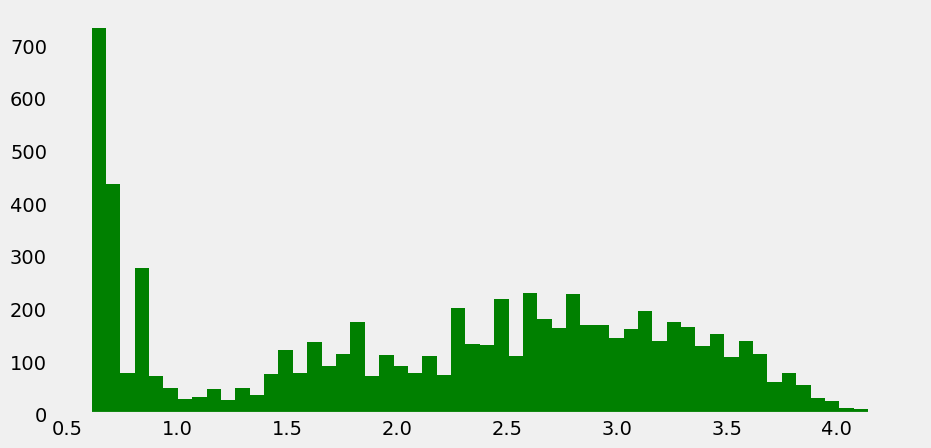

In [35]:
data['day_price'].hist(grid=False, figsize = (10,5), color='green', bins=55)
plt.show()

# Исследование коррелированности признаков

In [36]:
corr_phik = phik.phik_matrix(data)

interval columns not set, guessing: ['senior_citizen', 'partner', 'dependents', 'paperless_billing', 'monthly_charges', 'total_charges', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'target', 'days_use_contract', 'day_price']


Посмотрим, что по мнению phik сильнее всего коррелирует с таргетом. Как видим, **сильнее всего коррелирует с таргетом** month_of_use 
partner, payment_method  

In [37]:
corr_phik['target'].sort_values(ascending=False)

target               1.000000
days_use_contract    0.374101
total_charges        0.303758
multiple_lines       0.261345
online_backup        0.229736
partner              0.227597
day_price            0.226463
monthly_charges      0.225823
streaming_movies     0.221756
device_protection    0.218622
payment_method       0.214300
streaming_tv         0.200334
online_security      0.132914
tech_support         0.103933
type                 0.094622
senior_citizen       0.085708
paperless_billing    0.082789
internet_service     0.056279
dependents           0.048710
gender               0.008800
Name: target, dtype: float64

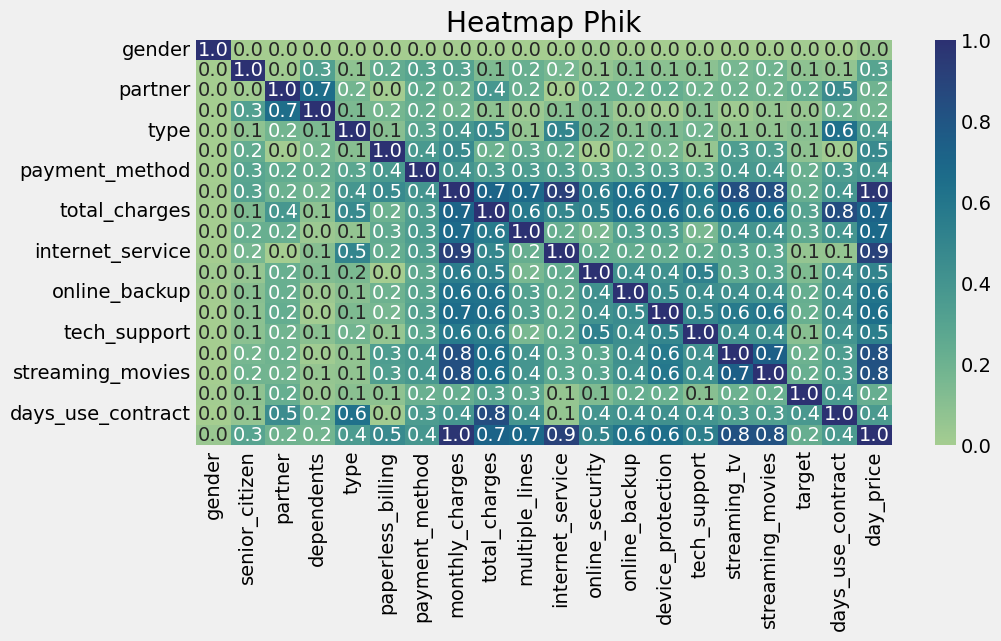

In [38]:
plt.figure(figsize=(10, 5))
sns.heatmap(corr_phik, annot=True, fmt=".1f", cmap="crest")
plt.title('Heatmap Phik');

По heatmap видим, что между переменными (между друг другом):
* internet_service
* interner_security
* online_backup
* device_protection
* tech_support
* streaming_tv
* streaming_movies

**Есть сильная корреляция! Следовательно нужно быть с этими фичами аккуратнее в линейных моделях!**


Также выделяется корреляция > 0.6 между фичами выше и type и multipline_lines!

## Разделяем на train и test

In [39]:
# используем stratify для сохранения баланса

train, test = train_test_split(data, test_size=TEST_SIZE, shuffle=True,
                              stratify=data['target'], random_state=RANDOM_STATE)

**Далее проведем EDA на train. Представим, что тестовой выборки для нас не существует.**

**Этапы EDA:**
1. Просмотр статистик: мер центральной тенденции и мер изменчивости
2. Посмотреть распределение целевого признака
3. Построение сводных таблиц
4. Исследование коррелированности признаков + heatmap


### Просмотр статистик

Видим, что:
- Распределение женщин\мужчин примерно 50/50
- Всего 16% пожилых людей
- 48% имеют партнера
- 30% имеют детей 
- 58% оплачивают безналичным расчетом
- В среднем услугами пользовались 30 месяцев. Медианная оценка 25 месяцов (робастая оценка)
- Target имеет сильный дисбаланс классов

In [40]:
train.describe()

senior_citizen      partner   dependents  paperless_billing  \
count     5274.000000  5274.000000  5274.000000        5274.000000   
mean         0.161926     0.482366     0.293705           0.592340   
std          0.368418     0.499736     0.455502           0.491446   
min          0.000000     0.000000     0.000000           0.000000   
25%          0.000000     0.000000     0.000000           0.000000   
50%          0.000000     0.000000     0.000000           1.000000   
75%          0.000000     1.000000     1.000000           1.000000   
max          1.000000     1.000000     1.000000           1.000000   

       monthly_charges  total_charges  multiple_lines  online_security  \
count      5274.000000    5274.000000     5274.000000      5274.000000   
mean         64.596938    2106.231185        0.422450         0.286310   
std          30.128603    2113.652331        0.493996         0.452079   
min          18.400000      19.050000        0.000000         0.000000   
25%          35.112500     427.692500        0.000000         0.000000   
50%          70.300000    1329.300000        0.000000         0.000000   
75%          89.850000    3214.247500        1.000000         1.000000   
max         118.750000    9221.380000        1.000000         1.000000   

       online_backup  device_protection  tech_support  streaming_tv  \
count    5274.000000        5274.000000   5274.000000   5274.000000   
mean        0.342814           0.338074      0.291240      0.379029   
std         0.474695           0.473099      0.454377      0.485191   
min         0.000000           0.000000      0.000000      0.000000   
25%         0.000000           0.000000      0.000000      0.000000   
50%         0.000000           0.000000      0.000000      0.000000   
75%         1.000000           1.000000      1.000000      1.000000   
max         1.000000           1.000000      1.000000      1.000000   

       streaming_movies       target  days_use_contract    day_price  
count       5274.000000  5274.000000        5274.000000  5274.000000  
mean           0.386993     0.156617         895.740994     2.175221  
std            0.487108     0.363474         684.772015     1.019291  
min            0.000000     0.000000          28.000000     0.613043  
25%            0.000000     0.000000         276.000000     1.167295  
50%            0.000000     0.000000         760.500000     2.360366  
75%            1.000000     0.000000        1461.000000     3.017774  
max            1.000000     1.000000        2314.000000     4.207613

### Распределение целевого признака

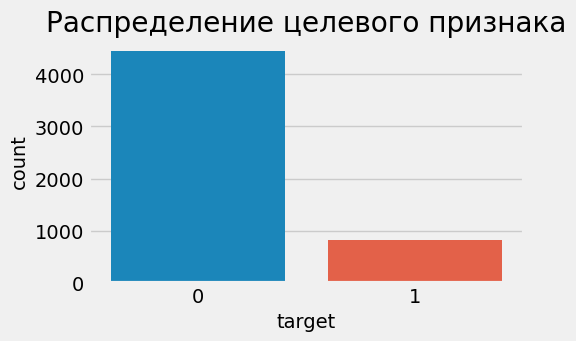

In [41]:
plt.figure(figsize=(5, 3))
sns.countplot(train, x='target')
plt.title('Распределение целевого признака');

Видим, что имеется сильный дисбаланс классов. Оно и понятно, ведь решаем задачу оттока клиентов

### Построение сводных таблиц

In [42]:
t = train.pivot_table(index='gender', values='target', aggfunc=['mean', 'count'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

mean_target  count_target
gender                           
Female     0.158681          2609
Male       0.154597          2665

**Из данного сводника видим, что наличие детей увеличивает шанс принятия решения на уход**

In [43]:
t = train.pivot_table(index='dependents', values='target', aggfunc=['mean', 'count'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

mean_target  count_target
dependents                           
0              0.148456          3725
1              0.176243          1549

**Из данного сводника видим, что наличие партнера увеличивает шанс на уход, практически в 2 раза**

In [44]:
t = train.pivot_table(index='partner', values='target', aggfunc=['mean', 'count'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

mean_target  count_target
partner                           
0           0.106593          2730
1           0.210299          2544

# План Работы

Построив гистограмму в разбивке по классам по переменной multiple_lines мы видим, что клиенты, ипользующие функцию multiple_lines больше склонны к уходу!

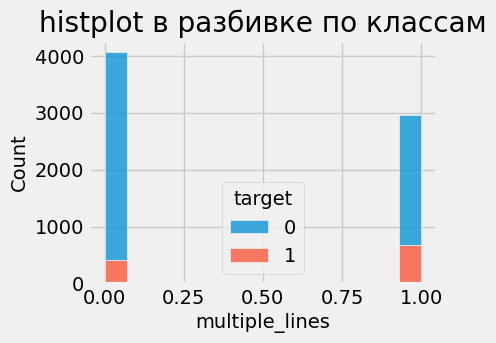

In [45]:
plt.figure(figsize=(4, 3))
sns.histplot(data, x='multiple_lines', hue='target', multiple='stack')
plt.title('histplot в разбивке по классам');

Построив гистограмму в разбивке по классам по переменной month_of_use мы видим, что клиенты, чаще всего уходят до 60 месяцев, причем чем дальше, тем меньше склонность к оттоку!

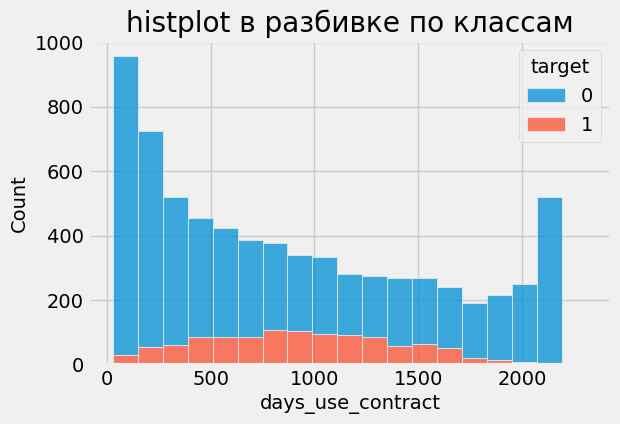

In [46]:
plt.figure(figsize=(6, 4))
sns.histplot(data, x='days_use_contract', hue='target', multiple='stack')
plt.title('histplot в разбивке по классам');

# Основная часть

Также **буду анализировать 2 метрики**:
1. ROC-AUC
2. F1-score

**В данной части проведем предобработку данных, построим Pipeline и обучим модели.**

В качестве моделей буду рассматривать:
1. SVM
2. Логистическая регрессия
3. Random Forest
4. CatBoostClassifier

На моделях **в качестве способа борьбы с дисбалансом** буду использовать:
* подбор порога на кросс-валидации
* с помощью библиотеки Imblearn метод oversampling'a SMOTE
* с помощью балансировки классов class_weight = 'balanced

Для избежания утечки данных буду применять Pipeline


### Функция подбора порога на кросс-валидации

In [47]:
def get_best_threshold(model, feature, target):
    best_thrashold = 0
    best_f1 = 0
    predictions_one = cross_val_predict(model, feature, target,
                                    method='predict_proba')[:, 1]
    
    for threshold in np.unique(predictions_one):
        predictions = predictions_one > threshold
        f1_sco = f1_score(train['target'], predictions)
        if f1_sco > best_f1:
            best_AUC = f1_sco
            best_thrashold = threshold
            
    print(f'best f1_score: {best_f1} threshold: {best_thrashold}')


### Pipeline

Pipeline состоит из:
1. Масштабирования данных
2. Кодирования данных
3. Over sampling
4. Создание модели

In [48]:

feature = ['senior_citizen', 'partner', 'dependents',
       'paperless_billing', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'days_use_contract',
       'day_price', 'payment_method', 'internet_service', 'type']

target = ['target']
# 

numeric_features =  train[feature].select_dtypes(include=['int', 'float', 'int16']).columns
categorical_features = train[feature].select_dtypes(include=['object']).columns


Теперь в процессе обучения будем работать с этим пространством признаков

In [49]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
                    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('sampling', SMOTE(n_jobs=-1, random_state=RANDOM_STATE)),
                      ('model', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))])

In [50]:
# пример pipeline
set_config(display='diagram')

pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('sampling', SMOTE(n_jobs=-1, random_state=220523)),
                ('model', LogisticRegression(n_jobs=-1, random_state=220523))])

Далее для деревянных моделей моделей буду использовать порядковое кодирование, так как они заметно быстрее обучаются на меньшем количестве признаков и не теряют в качестве.

Но для линейных моделей порядковое кодирование не подходит, потому что задает приоритет признакам, которого в природе данных нет. Поэтому для них лучше использовать OHE.

* Масштабированиe (**любым моделям, основанным на деревьях - МАСШТАБИРОВАНИЕ НЕ НУЖНО - бэггинг, бустинг, деревья решений, случайный лес**):
    * **Нормализация** (для моделей, которые основаны на **расстоянии**):
        * knn, kmeans, pca, tsne
    * **Стандартизация** (для линейных моделей, здесь мы центрируем данные, поскольку среднее в нуле, а std=1 ):
        * Регрессия, SVM и так далее, **любые линейные модели**

# Модели

Для занесения качества результатов модели создам таблицу.


In [51]:
rating = pd.DataFrame(columns=['ROC-AUC_cross_val', 'F1_score_cross_val'])
rating

Empty DataFrame
Columns: [ROC-AUC_cross_val, F1_score_cross_val]
Index: []

Напишем функцию для занесения результатов:

* Лучшая модель хранится в best_estimator__
* Лучшая оценка хранится в best_score

In [52]:
def estimated(gsv, name_model):
    metrics_columns = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
    final_metrics = pd.DataFrame(gsv.cv_results_)[metrics_columns].iloc[gsv.best_index_]
    
    f1_cross_val = final_metrics[1]
    ROC_AUC_cross_val = final_metrics[0]
    
    rating.loc[len(rating.index)] = [f1_cross_val, ROC_AUC_cross_val]
    rating.rename(index={(len(rating.index)-1): name_model}, inplace=True)

**Теперь напишем функцию для отрисовки графиков. Будем их отрисовывать на лучших параметрах после перебора на train**

In [53]:
def plot_graphics(best_model_gcv):
    
    fig = plt.figure()
    fig = plt.figure(figsize=(10,5))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
   
    
    disp_1 = RocCurveDisplay.from_estimator(gcv.best_estimator_, train[feature], train[target], ax = ax_1, name='train')

    ax_1.plot([1, 0], [1, 0], label='Random')
    ax_1.legend()
    disp_1.figure_.suptitle("ROC curve")
    
    
    cm = confusion_matrix((gcv.best_estimator_.predict(train[feature])), train['target'])
    f = sns.heatmap(cm, annot=True, fmt=".0f", ax=ax_2)
    plt.ylabel('Groud truth')
    plt.title('Матрица ошибок для train')
    plt.xlabel('Prediction');

**Для нас важнее не допускать ошибку FN (левый нижний столбец). Поскольку не столько страшно предсказать, что клиент уходит, сколько предсказать, что не уходит, а на самом деле клиент уйдет. Значит для нас важнее, чтобы ошибка FN была минимальна!**

## Baseline

В качестве baseline построим модель DummyClassifier.

In [55]:
dummy_model = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
dummy_model.fit(train[feature], train['target'])

DummyClassifier(random_state=220523, strategy='uniform')

**Посчитаем f1 и ROC-AUC:**

In [56]:
def return_metric(model, train):
    print('Модель: DummyClassifier')
    print('f1-score на train:', f1_score(train['target'], model.predict(train[feature])))
    print('ROC-AUC на train:', roc_auc_score(train['target'], model.predict(train[feature])))


In [57]:
return_metric(dummy_model, train)

Модель: DummyClassifier
f1-score на train: 0.23463687150837986
ROC-AUC на train: 0.49692110718205096


In [58]:
rating.loc[len(rating.index)] = [roc_auc_score(train['target'], dummy_model.predict(train[feature])),
                                 f1_score(train['target'], dummy_model.predict(train[feature]))]
rating.rename(index={(len(rating.index)-1): 'Dummy_Classifier'}, inplace=True)

In [59]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637

## SVC

Рассмотрим 2 варианта:
1. Борьба с дисбалансом с помощью SMOTE
2. Борьба с дисбалансом с помощью балансировки 


### SVC + SMOTE

In [60]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('sampling', SMOTE(random_state=RANDOM_STATE)),
                      ('model', SVC(probability=True, random_state=RANDOM_STATE))])

In [61]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('sampling', SMOTE(random_state=220523)),
                ('model', SVC(probability=True, random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [62]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'sampling__sampling_strategy' : ['all'],
              'sampling__k_neighbors' : [5, 6, 7], 
              'model__C': [1.0, 1.15]}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 14.2 s
Wall time: 1min 10s


0.7904561075662212

In [63]:
gcv.best_params_

{'model__C': 1.0,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'all'}

In [64]:
estimated(gcv, 'SVC_SMOTE')

In [65]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426

Проверим модель на train

<Figure size 640x480 with 0 Axes>

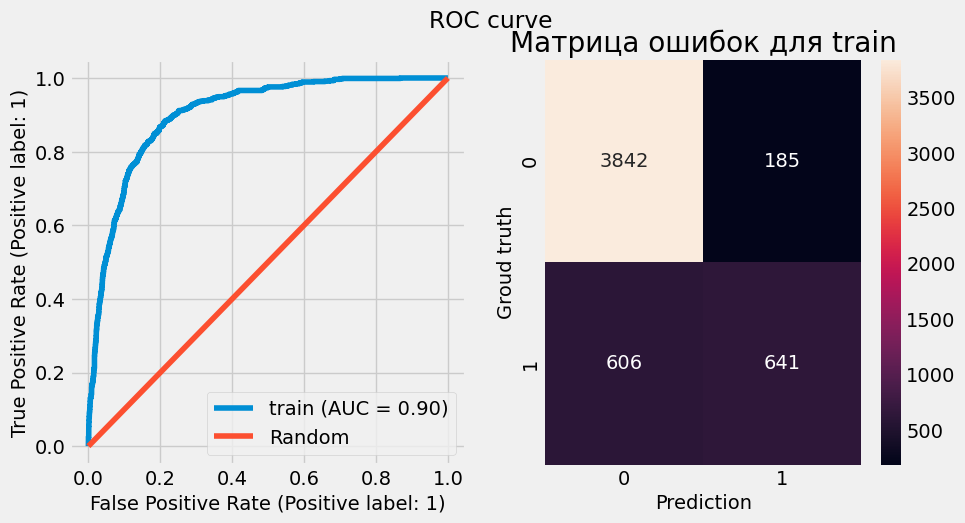

In [66]:
plot_graphics(gcv.best_estimator_);

На train модель показала AUC = 0.91. **Для нас важнее не допускать ошибку FN (левый нижний столбец)**. Анализируя матрицу ошибок, прихожу к выводу, что модель частно ошибается на FN.

### SVC + Балансировка классов

In [67]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('model', SVC(probability=True, random_state=RANDOM_STATE))])

In [68]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('model', SVC(probability=True, random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [69]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'model__degree': range(3, 5),
              'model__C': [1.0, 1.15],
              'model__class_weight' : ['balanced']}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 6.08 s
Wall time: 20.1 s


0.8051668607879827

In [70]:
gcv.best_params_

{'model__C': 1.0, 'model__class_weight': 'balanced', 'model__degree': 3}

In [71]:
estimated(gcv, 'SVC_balanced')

In [72]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426
SVC_balanced               0.805167            0.466769

Проверим модель на train

<Figure size 640x480 with 0 Axes>

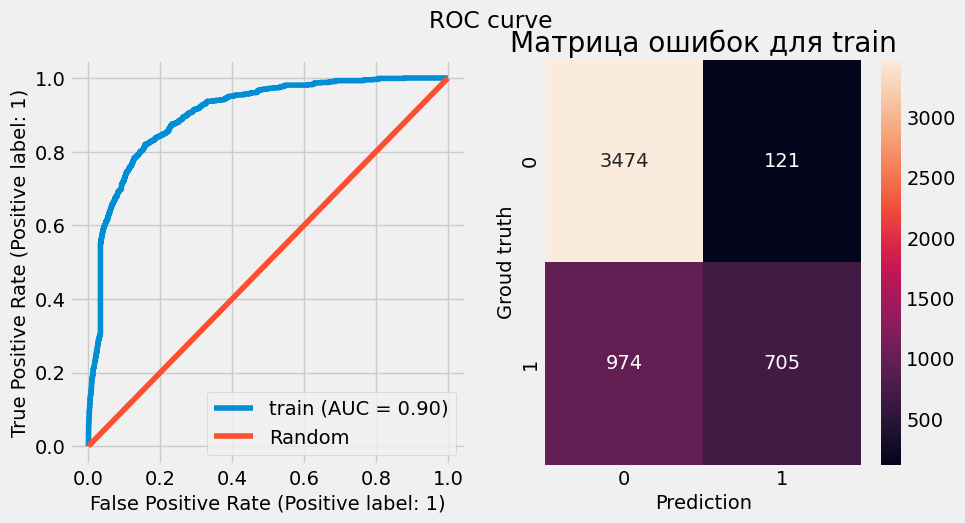

In [73]:
plot_graphics(gcv.best_estimator_);

На train модель показала AUC = 0.89. **Для нас важнее не допускать ошибку FN (левый нижний столбец)**. Анализируя матрицу ошибок, прихожу к выводу, что модель стала чаще ошибаться в FN, в сравнении с SMOTE.

## Логистическая регрессия 

Рассмотрим 2 варианта:
1. Борьба с дисбалансом с помощью SMOTE
2. Борьба с дисбалансом с помощью балансировки 


### LogReg + SMOTE

In [74]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('sampling', SMOTE(random_state=RANDOM_STATE)),
                      ('model', LogisticRegression(random_state=RANDOM_STATE))])

In [75]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('sampling', SMOTE(random_state=220523)),
                ('model', LogisticRegression(random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [76]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'sampling__sampling_strategy' : ['all'],
              'sampling__k_neighbors' : [5, 6, 7, 8], 
              'model__penalty': ['l2', 'l1'],
              'model__C': [1.0, 1.1, 1.15],
              'model__solver' : ['liblinear']}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 1.17 s
Wall time: 2.89 s


0.7545647150198623

In [77]:
gcv.best_params_

{'model__C': 1.15,
 'model__penalty': 'l2',
 'model__solver': 'liblinear',
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'all'}

In [78]:
estimated(gcv, 'LogReg_SMOTE')

In [79]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426
SVC_balanced               0.805167            0.466769
LogReg_SMOTE               0.754565            0.413089

Проверим модель на train

<Figure size 640x480 with 0 Axes>

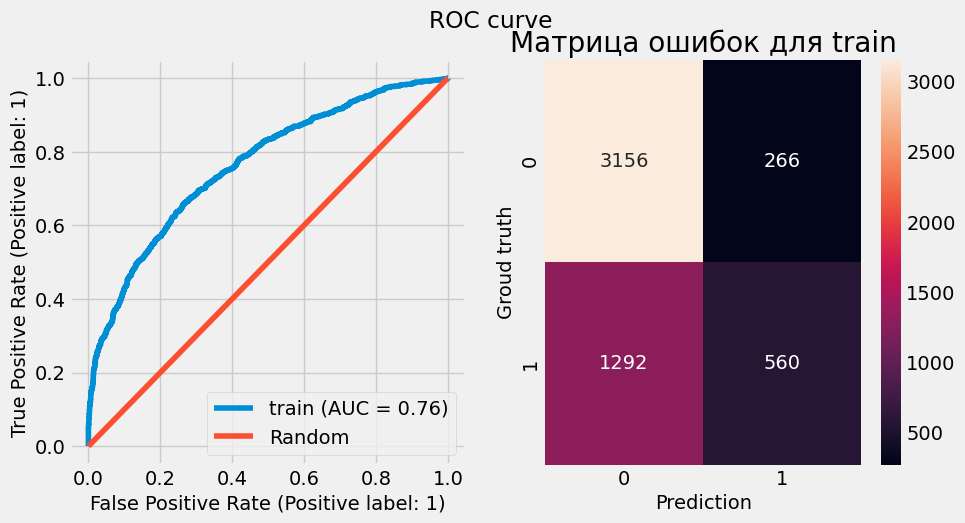

In [80]:
plot_graphics(gcv.best_estimator_);

### LogReg + Балансировка классов

In [81]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('model', LogisticRegression(random_state=RANDOM_STATE))])

In [82]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('model', LogisticRegression(random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [83]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'model__penalty': ['l2', 'l1'],
              'model__C': [1.0, 1.1, 1.15],
              'model__solver' : ['liblinear'],
              'model__class_weight': ['balanced']}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 203 ms
Wall time: 377 ms


0.7547202243356436

In [84]:
gcv.best_params_

{'model__C': 1.1,
 'model__class_weight': 'balanced',
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [85]:
estimated(gcv, 'LogReg_balanced')

In [86]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426
SVC_balanced               0.805167            0.466769
LogReg_SMOTE               0.754565            0.413089
LogReg_balanced            0.754720            0.404635

Проверим модель на train

<Figure size 640x480 with 0 Axes>

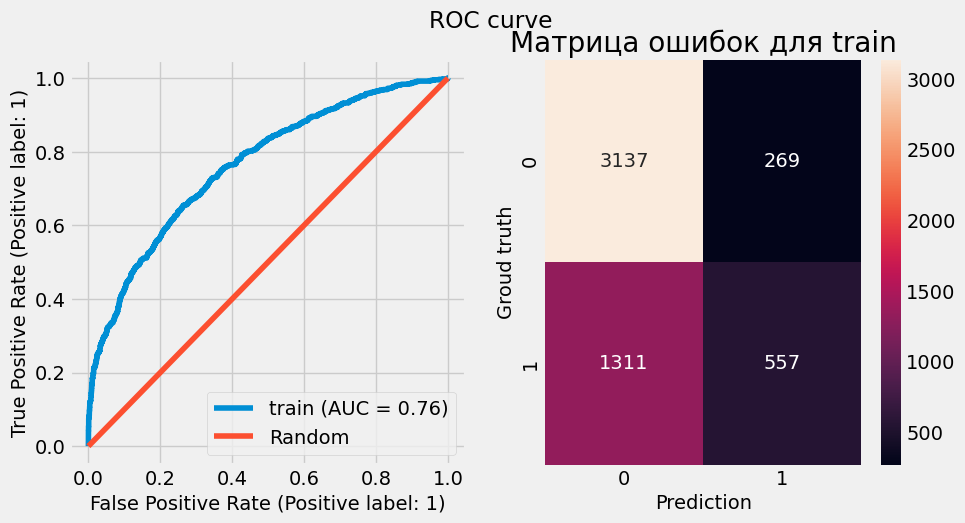

In [87]:
plot_graphics(gcv.best_estimator_);

## Random Forest

Рассмотрим 2 варианта:
1. Борьба с дисбалансом с помощью SMOTE
2. Борьба с дисбалансом с помощью балансировки 


### RF + SMOTE

In [88]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                    ('ordinal', OrdinalEncoder(encoded_missing_value=-1))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('sampling', SMOTE(random_state=RANDOM_STATE)),
                      ('model', RandomForestClassifier(random_state=RANDOM_STATE))])

In [89]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(encoded_missing_value=-1))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('sampling', SMOTE(random_state=220523)),
                ('model', RandomForestClassifier(random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [90]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'sampling__sampling_strategy' : ['all'],
              'sampling__k_neighbors' : [5, 6, 7], 
              'model__min_samples_leaf': range(3, 6),
              'model__max_depth': range(9, 12),
              'model__n_estimators' : [150, 200]}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 3.48 s
Wall time: 47.1 s


0.8255193447127734

In [91]:
gcv.best_params_

{'model__max_depth': 9,
 'model__min_samples_leaf': 3,
 'model__n_estimators': 200,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'all'}

In [92]:
estimated(gcv, 'RF_SMOTE')

In [93]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426
SVC_balanced               0.805167            0.466769
LogReg_SMOTE               0.754565            0.413089
LogReg_balanced            0.754720            0.404635
RF_SMOTE                   0.825519            0.490328

Проверим модель на train

<Figure size 640x480 with 0 Axes>

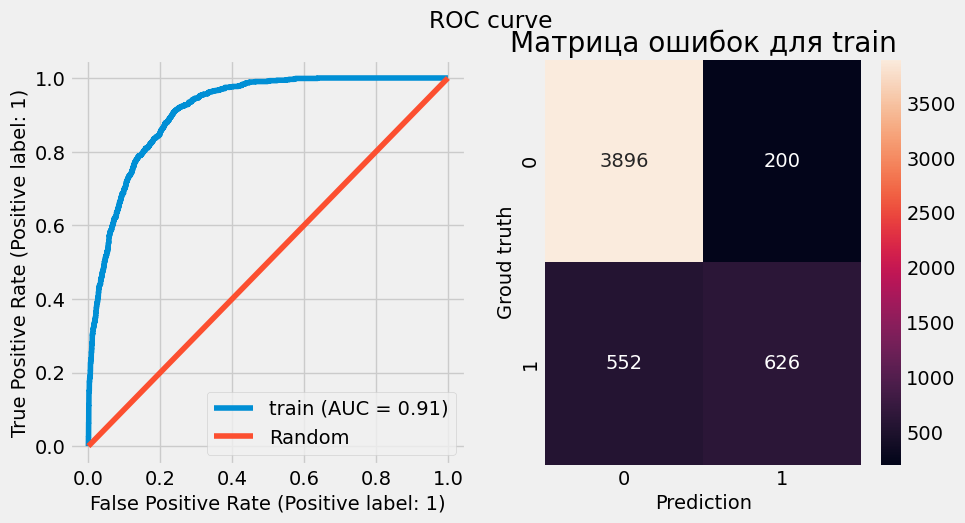

In [94]:
plot_graphics(gcv.best_estimator_);

### RF + Балансировка классов

In [95]:
numeric_transformer = Pipeline(steps=[
                    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
                            ('ordinal', OrdinalEncoder(encoded_missing_value=-1))
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

pipe = Pipeline(steps=[('preprocessor_feature', preprocessor),
                      ('model', RandomForestClassifier(random_state=RANDOM_STATE))])

In [96]:
pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['senior_citizen', 'partner', 'dependents', 'paperless_billing',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'days_use_contract', 'day_price'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(encoded_missing_value=-1))]),
                                                  Index(['payment_method', 'internet_service', 'type'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=220523))])

**Воспользуемся GridsearchCV с StratifiedKFold**

In [97]:
%%time


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


parameters = {
              'model__min_samples_leaf': range(6, 9),
              'model__max_depth': range(12, 15),
              'model__n_estimators' : [150],
              'model__class_weight': ['balanced', 'balanced_subsample']}

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf,
                         refit='roc_auc', scoring=['f1', 'roc_auc'])

gcv.fit(train[feature], train['target'])

gcv.best_score_

CPU times: total: 1.08 s
Wall time: 9.87 s


0.8292916808150252

In [98]:
gcv.best_params_

{'model__class_weight': 'balanced',
 'model__max_depth': 13,
 'model__min_samples_leaf': 8,
 'model__n_estimators': 150}

In [99]:
estimated(gcv, 'RF_balanced')

In [100]:
rating

ROC-AUC_cross_val  F1_score_cross_val
Dummy_Classifier           0.496921            0.234637
SVC_SMOTE                  0.790456            0.457426
SVC_balanced               0.805167            0.466769
LogReg_SMOTE               0.754565            0.413089
LogReg_balanced            0.754720            0.404635
RF_SMOTE                   0.825519            0.490328
RF_balanced                0.829292            0.510867

Проверим модель на train

<Figure size 640x480 with 0 Axes>

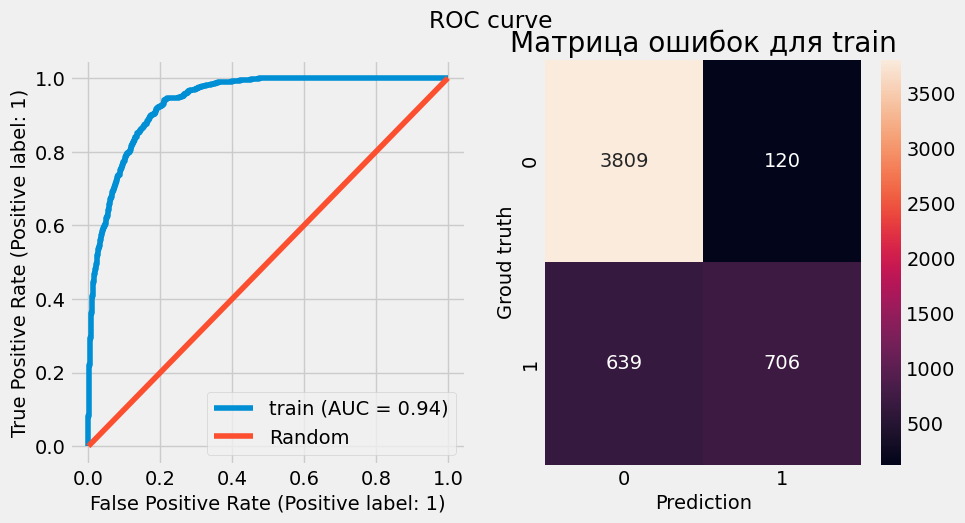

In [101]:
plot_graphics(gcv.best_estimator_);

**Посмотрим на важность признаков**

In [102]:
importances = gcv.best_estimator_._final_estimator.feature_importances_
importances

array([0.01356538, 0.0427436 , 0.01530879, 0.01583711, 0.05948443,
       0.01411416, 0.03204068, 0.02687585, 0.0130773 , 0.01398527,
       0.0220534 , 0.39510986, 0.16241219, 0.05639173, 0.01687369,
       0.10012655])

In [103]:
forest_importances = pd.Series(importances, index=feature).sort_values(ascending=True)

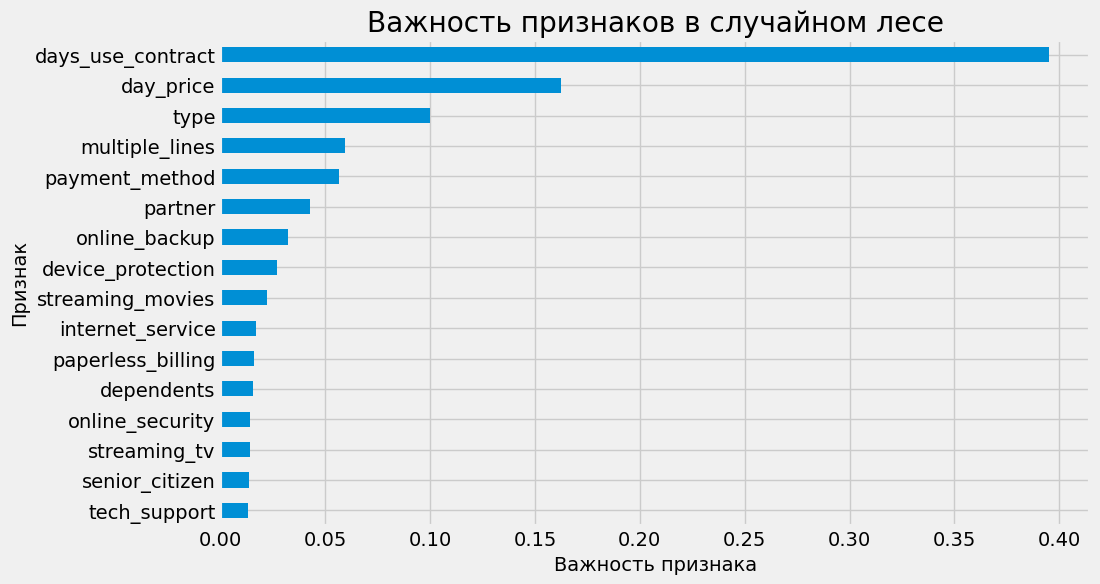

In [104]:
# Построение графика важности признаков
plt.figure(figsize=(10, 6))
forest_importances.plot.barh()
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в случайном лесе')
plt.show()

Как видим, по мнению RF самым важным признаком является время использования контракта, затем цена дня, далее тип.

## CatBoostClassifier

In [105]:

feature = ['senior_citizen', 'partner', 'dependents',
       'paperless_billing', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'days_use_contract',
       'day_price', 'payment_method', 'internet_service', 'type']

target = ['target']
# 
text_features = ['payment_method', 'internet_service', 'type']



In [106]:
train_data = Pool(data=train[feature],
                 label=train[target],
                 text_features=text_features)



In [107]:
model = CatBoostClassifier()

grid = {'learning_rate': np.linspace(0.2, 0.3, 10),
        'depth': [2],
        'l2_leaf_reg': [1, 2],
        'auto_class_weights': ['Balanced']}



In [108]:
model = CatBoostClassifier()

grid_search_result = model.grid_search(grid, train_data,
                                       partition_random_seed=RANDOM_STATE,
                                       shuffle=True,
                                       train_size=0.75,
                                       stratified=True)


0:	learn: 0.6666640	test: 0.6706754	best: 0.6706754 (0)	total: 151ms	remaining: 2m 31s
1:	learn: 0.6384813	test: 0.6426463	best: 0.6426463 (1)	total: 153ms	remaining: 1m 16s
2:	learn: 0.6209356	test: 0.6244819	best: 0.6244819 (2)	total: 155ms	remaining: 51.4s
3:	learn: 0.6052598	test: 0.6068462	best: 0.6068462 (3)	total: 156ms	remaining: 38.9s
4:	learn: 0.5964644	test: 0.5970403	best: 0.5970403 (4)	total: 158ms	remaining: 31.4s
5:	learn: 0.5883555	test: 0.5883624	best: 0.5883624 (5)	total: 160ms	remaining: 26.4s
6:	learn: 0.5825077	test: 0.5801972	best: 0.5801972 (6)	total: 161ms	remaining: 22.9s
7:	learn: 0.5770503	test: 0.5766427	best: 0.5766427 (7)	total: 163ms	remaining: 20.2s
8:	learn: 0.5709872	test: 0.5714099	best: 0.5714099 (8)	total: 164ms	remaining: 18.1s
9:	learn: 0.5645026	test: 0.5649912	best: 0.5649912 (9)	total: 166ms	remaining: 16.4s
10:	learn: 0.5607817	test: 0.5622197	best: 0.5622197 (10)	total: 167ms	remaining: 15s
11:	learn: 0.5517663	test: 0.5517805	best: 0.5517805

In [109]:
grid_search_result

{'params': {'depth': 2,
  'l2_leaf_reg': 2,
  'learning_rate': 0.25555555555555554,
  'auto_class_weights': 'Balanced'},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
      

**Подобрав лучшие параметры, проведем кросс-валидацию для получения устойчивой оценки**

In [110]:
params = {'verbose':100, 
          'random_seed':RANDOM_STATE, 
          'eval_metric': 'AUC', 
          'loss_function': 'Logloss',
          'depth': 2,
          'l2_leaf_reg': 1,
          'learning_rate': 0.2346938775510204,
         'auto_class_weights': 'Balanced'}


In [111]:
cv_data_ROC_AUC = cv(params=params,
            pool=train_data,
            fold_count=5,
            shuffle=True,
            partition_random_seed=RANDOM_STATE,
            stratified=True,
            verbose=False)

Training on fold [0/5]

bestTest = 0.9187897658
bestIteration = 981

Training on fold [1/5]

bestTest = 0.915566905
bestIteration = 828

Training on fold [2/5]

bestTest = 0.9210963568
bestIteration = 960

Training on fold [3/5]

bestTest = 0.916037768
bestIteration = 987

Training on fold [4/5]

bestTest = 0.9231107475
bestIteration = 908



In [112]:
rating.loc[len(rating.index)] = [pd.DataFrame(cv_data_ROC_AUC)['test-AUC-mean'].max(), np.nan]
rating.rename(index={(len(rating.index)-1): 'CatBoost'}, inplace=True)

## Выбор лучшей модели

In [113]:
rating.sort_values(by='ROC-AUC_cross_val', ascending=False)\
      .style.background_gradient(axis=0, cmap='YlOrRd')  

**Как видим из таблицы лучшие показали на кросс-валидации у градиентного бустинга - 0.91. Соответственного его мы и выбираем как лучшую модель. На нем и будем проводить тест.**

**Установим параметры и обучим модель**

In [114]:
test_data = Pool(data=test[feature],
                 label=test[target],
                 text_features=text_features)

In [115]:
params = {'verbose':100, 
          'random_seed':RANDOM_STATE, 
          'eval_metric': 'AUC', 
          'loss_function': 'Logloss',
          'depth': 2,
          'l2_leaf_reg': 1,
          'learning_rate': 0.2346938775510204,
         'auto_class_weights': 'Balanced'}

model = CatBoostClassifier(**params)
model.fit(train_data)

0:	total: 2.63ms	remaining: 2.63s
100:	total: 183ms	remaining: 1.63s
200:	total: 370ms	remaining: 1.47s
300:	total: 551ms	remaining: 1.28s
400:	total: 719ms	remaining: 1.07s
500:	total: 898ms	remaining: 894ms
600:	total: 1.07s	remaining: 711ms
700:	total: 1.24s	remaining: 530ms
800:	total: 1.42s	remaining: 353ms
900:	total: 1.59s	remaining: 175ms
999:	total: 1.75s	remaining: 0us


Посчитаем метрику качества. Для ROC-AUC мы должны применять метод predict_proba, поскольку расчет метрики нужно проводить по вероятностям принадлежности к классу 1.

In [116]:
roc_auc_score(test[target], model.predict_proba(test_data)[:, 1])

0.9333795132716238

**Метрика пробила порог 0.85!**

Рассмотрим важность признаков по мнению CatBoost

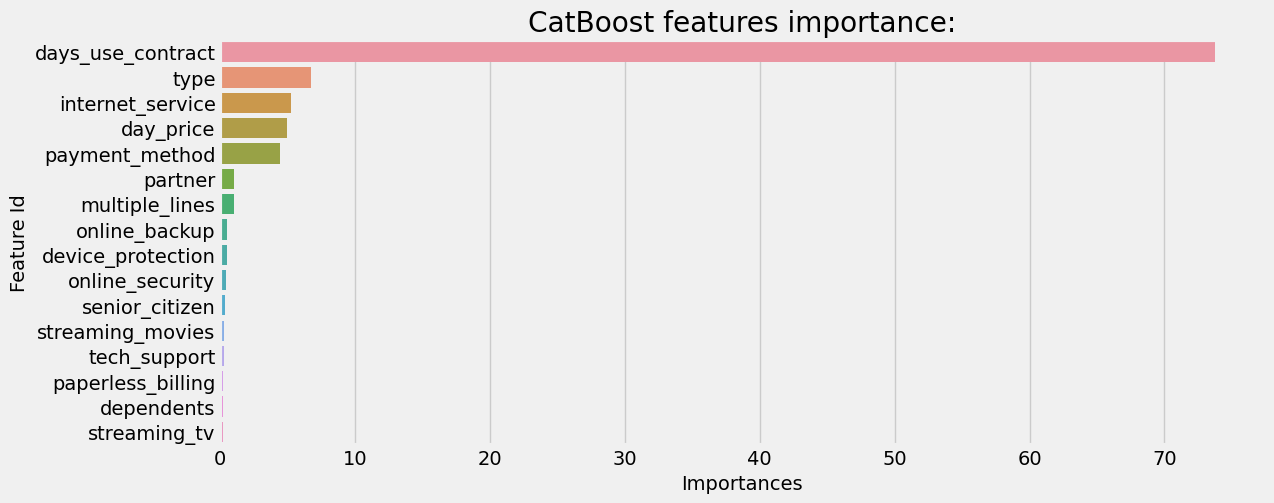

In [117]:
fi = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 5));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

**CatBoost отдает предпочтение фиче days_use_contract, она внесла наибольший вклад.**

## Анализ лучшей модели

Проведем анализ лучшей модели с помощью библиотеки Shap. Это необходимо для того, чтобы лучше понять как значения влияют на предсказание модели!

In [118]:
# теперь рассчитаем shap_values, для этого пишем

explainer = shap.TreeExplainer(model) # передаем нашу модель объяснителю
shap_values = explainer.shap_values(test_data)

In [119]:
pd.DataFrame(shap_values, columns=feature)

senior_citizen   partner  dependents  paperless_billing  multiple_lines  \
0          -0.070038  0.273594    0.116234           0.105068        0.413341   
1          -0.042352 -0.433683    0.019861          -0.144329       -0.305834   
2          -0.043632  0.259946   -0.042012          -0.151514        0.372541   
3          -0.041825  0.331491   -0.022331           0.094344        0.251939   
4           0.318380 -0.361967   -0.051902           0.107709       -0.424884   
...              ...       ...         ...                ...             ...   
1753       -0.098792 -0.387290    0.019177           0.136367       -0.420160   
1754       -0.027125 -0.514103   -0.042946           0.150274       -0.439913   
1755       -0.040158 -0.514103    0.019177           0.136367       -0.389630   
1756       -0.060854  0.246078    0.029066          -0.176861        0.372541   
1757       -0.079055  0.274552   -0.065094          -0.234583       -0.408389   

      online_security  online_backup  device_protection  tech_support  \
0           -0.118721       0.328060           0.204000      0.061888   
1           -0.120741      -0.202709          -0.100814      0.058619   
2           -0.152665       0.277431           0.159783      0.098066   
3           -0.120741      -0.202709          -0.100814      0.067544   
4           -0.135556       0.328060          -0.132488      0.061888   
...               ...            ...                ...           ...   
1753        -0.098205      -0.239726           0.397936      0.098066   
1754         0.413987      -0.239658          -0.243483     -0.057555   
1755        -0.111492      -0.239726          -0.215082      0.061888   
1756        -0.139804       0.338041          -0.149435     -0.150301   
1757         0.299149       0.368564          -0.187653     -0.150301   

      streaming_tv  streaming_movies  days_use_contract  day_price  \
0         0.067424         -0.095560           0.193806  -0.532604   
1         0.006928         -0.128567          -1.859553  -0.551037   
2        -0.082042         -0.095560          -2.183389   0.027472   
3         0.006928         -0.115007          -1.406403  -0.166289   
4         0.067424         -0.109119           2.825534   0.024396   
...            ...               ...                ...        ...   
1753     -0.003368          0.131911          -0.831977  -0.047038   
1754      0.006928          0.095057          -1.132170  -0.431751   
1755     -0.036352          0.253341          -1.414220  -0.160718   
1756      0.006928         -0.095560           1.825686  -0.232621   
1757      0.006928         -0.078633           1.028207  -0.302637   

      payment_method  internet_service      type  
0           0.188454         -0.022100 -0.973551  
1          -0.611756         -0.204630  1.256846  
2           0.183479         -0.260682 -0.820887  
3          -0.566776         -0.470934  0.189092  
4           0.093499          0.160648 -0.894972  
...              ...               ...       ...  
1753       -0.018590          0.236739 -0.746028  
1754        0.288093          0.045311 -0.777054  
1755       -0.619474          0.129480 -0.678555  
1756        0.281128          0.219990 -0.575197  
1757        0.314760          0.235326 -0.827299  

[1758 rows x 16 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


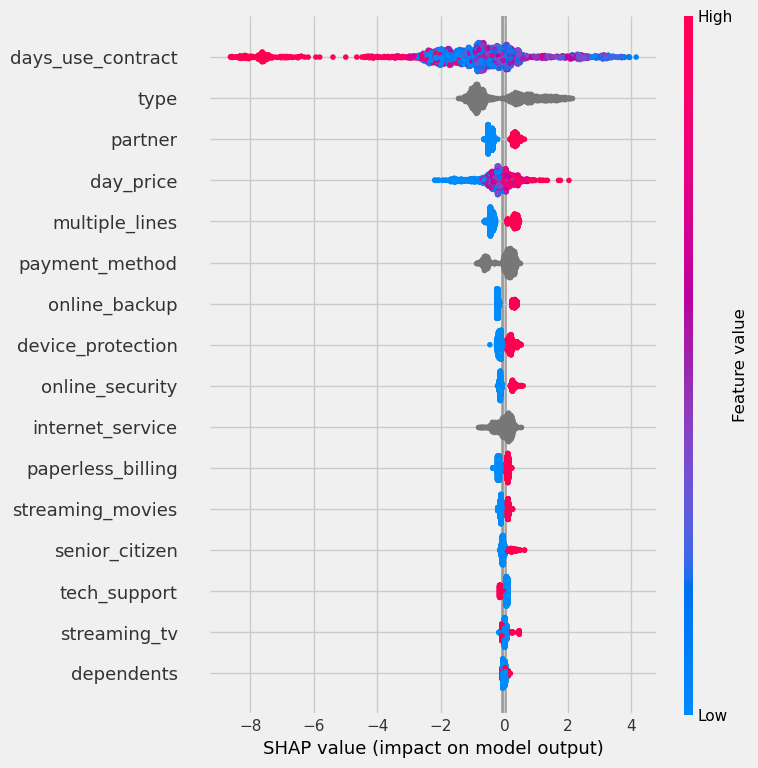

In [120]:
# и начнем анализ с построения summary_plot, в идеале с него всегда и начинать

shap.summary_plot(shap_values, test[feature])

# передаем ему shap_values и сами данные по фичам

**И теперь мы видим подробнее, что модель ставит score выше тем наблюдениям, в которых количество дней меньше, в таких случаях шанс оттока выше!** 

**Рассмотрим главную фичу подробнее**

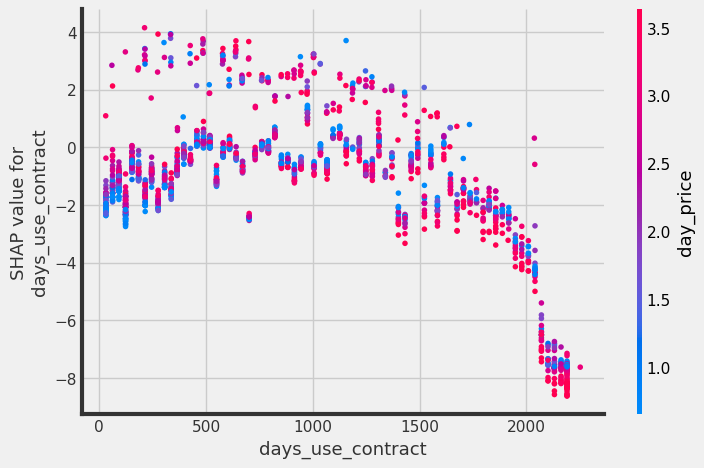

In [121]:
shap.dependence_plot('days_use_contract', shap_values, test[feature])


Анализируя график видим, что чем меньше дней человек имел контракт, тем выше шанс его ухода (score высокий). Правая часть графика имеет низкий score, там находятся люди с долгим временем использования.

# Часть 3: Отчет

**Шаги плана**:

*   * Загрузка и предобработка данных.
    * EDA + feature selection
    * Написание Pipeline + выбор моделей для обучения. В данной работе использовал 4 модели (Логистическая регрессия, SVM, RF, Градиентный бустинг)
    * Обучение моделей. Выбор лучшей
    * Анализ моделей с помощью SHAP
    * Выводы
    
Работа выполнена в соответствии с планом!)



**Ключевые шаги в достижении высокой метрики:**
    * Подбор learning_rate
    * Балансировка классов
    * Использование регуляризации
    * Ограничение глубины построения деревьев


**Описание лучше модели и ее гиперпараметров**

Самая лучшая модель в итоге - градиентный бустинг (CatBoost). Он показал метрику roc_auc на test 0.93, а на кросс-валидиации 0.91, это говорит о том, что была выбрана оптимальная стратегия борьбы с переобучением - регуляризация и огранчиение глубины дерева. Лучшие параметры catboost:

```python
params = {'verbose':100, 
          'random_seed':RANDOM_STATE, 
          'eval_metric': 'AUC', 
          'loss_function': 'Logloss',
          'depth': 2,
          'l2_leaf_reg': 1,
          'learning_rate': 0.2346938775510204,
         'auto_class_weights': 'Balanced'}
```



**Какие признаки использовались и как были сгенерированы**
```python
Пространство признаков:

feature = ['senior_citizen', 'partner', 'dependents',
       'paperless_billing', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'days_use_contract',
       'day_price', 'payment_method', 'internet_service', 'type']
```

Были сгенерированы признаки days_use_contract и day_price. Признаки, на которых они строились были удалены для избежания утечек и переобучения. days_use_contract рассчитывался как разница между началом договора и последним днем в столбце end_date, если там был пропуск, то мы выставляли дату сбора данных (2020-02-01). day_price - средняя стоимость одного для обслуживания для каждого клиента, то есть отношение total_charge к days_use_contract.

**Как происходила предобработка данных**

В предобработке данных применялся Pipeline от Imblearn, чтобы избежать утечки данных и корректно применить методы oversampling.  Использовал масштабирование данных (стандартизацию для линейных и деревянных моделей). В кодировании для деревянных моделей использовал OrdinalEncoder, а в линейных моделях OHE. В total_charge были обнаружены аномалии в виде пробелов и удалены. В фиче internet_service пропуски были заменены на 'no_data'. В остальных фичах, после преобразования их из object в int пропуски были заполнены значением 0.
